In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import connectheroku as cheroku # connect database function

In [2]:
large = 22; med = 16; small = 12
params = {'axes.titlesize' : large,
          'legend.fontsize' : med,
          'figure.figsize' : (16, 10),
          'axes.labelsize' : med,
          'xtick.labelsize' : med,
          'ytick.labelsize' : med,
          'figure.titlesize' : large
}
plt.rcParams.update(params)
sns.set_style('white')
all_shapes = list(mpl.markers.MarkerStyle.markers.keys())

In [3]:
credential_file = '/Users/aliglara/Documents/MyGit/apis/credential_keys.json'

# Introduction 
## Scope

The goal of this project was to create a data-driven tool to visualize whether there is a link between rising rent cost and homelessness among people who possesses a bachelor's degree or above in the United States.

## Dataset

The data used in this project was obtained from two US-official sources between 2015 to 2020.

First, the estimated US population will be grabbed from the US Census website, filtered by the following topics:

1. Geography > Nation > United States
2. Population and People > Population and People

Besides the broad information that can be obtained, this project was focused on the following features:

- Name of the state
- Year
- Total population
- Population in households
- Educational attainment
- Employment status
- Income
- Housing tenure
- Gross rent cost

Second, The estimate of homelessness population by state was pulled out from the HUD Exchange website

**The dataset was stored on my Heroku server to brush up on SQL coding. However, the original csv files are available in the GitHub repository. Click on -> ([link](https://github.com/aliglara/capstone-c1-DA/tree/main/data))**


# Exploratory Data Analysis (EDA)

The EDA was split in the following sections:
1. General population data
2. Homeless population data
3. Gross rent increase
4. Income and rent expenses by bachelor's professional or above

# General population data

In [4]:
query = ("SELECT year, name_state, population, pop_in_labor_force, "
         "total_population_25_years_and_over_educ_attainment, "
         "population_25_years_and_over_no_schooling_completed, "
         "population_25_years_and_over_bachelor_degree, "
         "population_25_years_and_over_master_degree + population_25_years_and_over_doctorate_degree AS  Pop_25y_master_over "
         "FROM us_population")

general_data_df = cheroku.make_query(query, "c1_capstone", credential_file)

In [5]:
# Verify if there are null values

print(general_data_df.isnull().sum())

year                                                   0
name_state                                             0
population                                             0
pop_in_labor_force                                     0
bachelor_or_higher_pop_in_labor_force                  0
total_population_25_years_and_over_educ_attainment     0
population_25_years_and_over_no_schooling_completed    0
population_25_years_and_over_bachelor_degree           0
pop_25y_master_over                                    0
dtype: int64


In [6]:
general_data_df.rename({
    "year": "Year",
    "name_state": "State name",
    "population": "Total pop.",
    "pop_in_labor_force": "Pop. in labor force",
    "total_population_25_years_and_over_educ_attainment": "Pop. 25year+",
    "population_25_years_and_over_no_schooling_completed": "Pop. 25year+ no schooling",
    "population_25_years_and_over_bachelor_degree": "Pop. 25year+ bachelor",
    "pop_25y_master_over": "Pop. 25year+ master over"
}, axis='columns', inplace=True)

In [7]:
general_data_df.set_index(["Year", "State name"], inplace=True)

In [9]:
general_data_df

Total pop.  Pop. in labor force  \
Year State name                                      
2015 Mississippi      2992333              1335130   
     Missouri         6083672              3062893   
     Montana          1032949               516733   
     Nebraska         1896190              1025079   
     Nevada           2890845              1455305   
...                       ...                  ...   
2020 Delaware          967679               489325   
     Puerto Rico      3255642              1210925   
     Kentucky         4461952              2121356   
     South Dakota      879336               466573   
     Tennessee        6772268              3343918   

                   Pop. bachelor+ in labor force  Pop. 25year+  \
Year State name                                                  
2015 Mississippi                          268930       1952337   
     Missouri                             813903       4097212   
     Montana                              141994        706329   
     Nebraska                             275822       1232583   
     Nevada                               297028       1968167   
...                                          ...           ...   
2020 Delaware                             144720        679870   
     Puerto Rico                          392981       2331294   
     Kentucky                             529472       3034491   
     South Dakota                         119925        580244   
     Tennessee                            909641       4649847   

                   Pop. 25year+ no schooling  Pop. 25year+ bachelor  \
Year State name                                                       
2015 Mississippi                       28332                 253036   
     Missouri                          35703                 706922   
     Montana                            3347                 144135   
     Nebraska                          12252                 244556   
     Nevada                            32904                 304948   
...                                      ...                    ...   
2020 Delaware                           5984                 129092   
     Puerto Rico                       55264                 443697   
     Kentucky                          32604                 447884   
     South Dakota                       4571                 116400   
     Tennessee                         49000                 826947   

                   pop_25y_master_over  
Year State name                         
2015 Mississippi                223786  
     Missouri                   640856  
     Montana                    100088  
     Nebraska                   180058  
     Nevada                     224390  
...                                ...  
2020 Delaware                   134714  
     Puerto Rico                245304  
     Kentucky                   447172  
     South Dakota                74444  
     Tennessee                  678030  

[312 rows x 7 columns]

In [10]:
general_data_df2020 = general_data_df.loc[2020]

In [13]:
pop_features_2020 = general_data_df2020.pivot_table(index="State name", aggfunc=sum)

In [16]:
import squarify

In [48]:
df = pop_features_2020.sum().reset_index(name='total')

In [49]:
df.sort_values("total", ascending=False, inplace=True)
df["norm"] = df["total"].apply(lambda x: x/df["total"].max() * 100).round()

In [50]:
df = df.reset_index(drop=True)

In [51]:
df.loc[1:]

,index,total,norm
1,Pop. 25year+,225168128,68.0
2,Pop. in labor force,167113763,51.0
3,Pop. bachelor+ in labor force,51234055,16.0
4,Pop. 25year+ bachelor,45478307,14.0
5,pop_25y_master_over,40665846,12.0
6,Pop. 25year+ no schooling,3513496,1.0


In [54]:
sizes = df["norm"][1:].values.tolist()
norms = squarify.normalize_sizes(sizes, dx=3, dy=3)
labels = df.loc[1:].apply(lambda x: str(x[0]) + '\n (' + str(x[2]) + ')', axis=1)


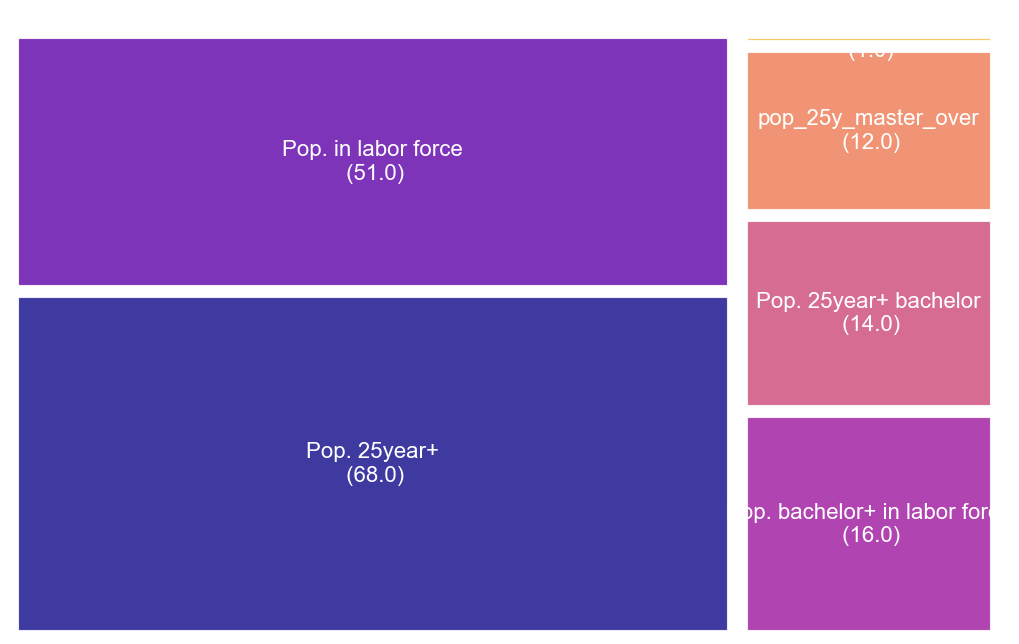

In [56]:
color = 'white'
mpl.rcParams['text.color'] = color
mpl.rcParams['font.size'] = 20
cmap = mpl.cm.get_cmap('plasma')
mapped_list = [cmap(i) for i in np.arange(0, 1, 1/len(sizes))]
plt.figure(dpi= 80)
squarify.plot(sizes=norms, 
              label=labels, 
              color=mapped_list,
              alpha=.8, 
              pad=True)
plt.title('Treemap of some US-population features from 2020')
plt.axis('off')
plt.show()


# Grabbing homelessness data

The dataset is taking from a Heroku server in order to brush up on SQL coding. However, the original csv files are available in the GitHub repository
Click on -> ([link](https://github.com/aliglara/capstone-c1-DA/tree/main/data))

Let's grab all the information about US homeless population available

In [5]:
query = ("SELECT ohr.year, ohr.abbreaviation, ohr.homeless_pop "
         "FROM overall_homeless AS ohr "
         "ORDER BY ohr.abbreaviation")

homeless_df = cheroku.make_query(query, "c1_capstone", credential_file)

In [6]:
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           336 non-null    int64  
 1   abbreaviation  336 non-null    object 
 2   homeless_pop   328 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.0+ KB


There are some null values in the homeless_pop field. Let's see what we have

In [7]:
homeless_df[homeless_df["homeless_pop"].isnull()]

,year,abbreaviation,homeless_pop
18,2019,AS,NaN
19,2020,AS,NaN
20,2015,AS,NaN
21,2016,AS,NaN
22,2018,AS,NaN
23,2017,AS,NaN
163,2015,MP,NaN
164,2016,MP,NaN


There is no information from American Samoa (AS) and Northern Mariana Islands (MP). Therefore it's possible to rid of those unincorporated US territories

In [8]:
df_clean = homeless_df[(homeless_df["abbreaviation"] != "AS") & (homeless_df["abbreaviation"] != "MP")]
df_clean.reset_index(inplace=True, drop=True)

In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           324 non-null    int64  
 1   abbreaviation  324 non-null    object 
 2   homeless_pop   324 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.7+ KB


In [10]:
df_clean.head()

,year,abbreaviation,homeless_pop
0,2017,AK,1845.0
1,2018,AK,2016.0
2,2015,AK,1956.0
3,2019,AK,1907.0
4,2016,AK,1940.0


# Visualizations

The data was taken from [Homelessness Data Exchange](https://www.hudhdx.info/) website where is recorded people experiencing homelessness.
There are several fields reported but this project only is focused on the total homeless population by state per year

## What is the reported total homeless population by year

In [11]:
total_hom_pop = df_clean.pivot_table(index="year", aggfunc="sum")
total_hom_pop

,homeless_pop
year,
2015,564708.0
2016,549928.0
2017,550324.0
2018,551786.0
2019,565908.0
2020,579259.0


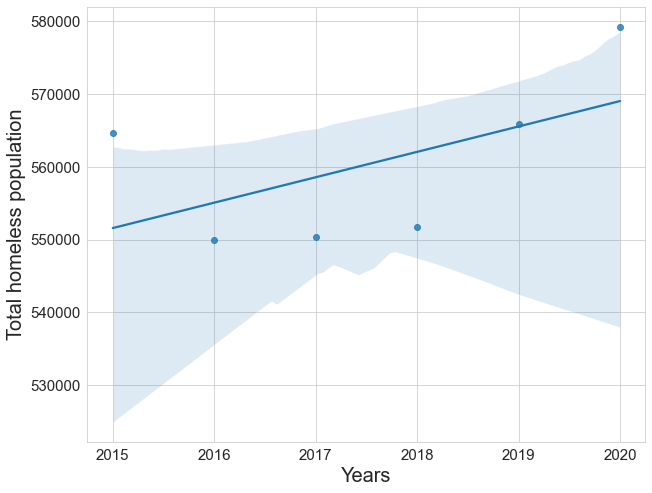

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
p = sns.regplot(x=total_hom_pop.index, y="homeless_pop", data=total_hom_pop)
p.set_ylabel("Total homeless population", fontsize = 20)
p.set_xlabel("Years", fontsize = 20)
p.tick_params(axis='both', which='major', labelsize=15)

plt.show()

Based on latter calculation, the homeless population has increased since 2018.
## What is its yearly percentage change?

In [13]:
total_hom_pop["Percentage change (%)"] = total_hom_pop["homeless_pop"].pct_change() * 100

In [14]:
total_hom_pop

,homeless_pop,Percentage change (%)
year,,
2015,564708.0,NaN
2016,549928.0,-2.617282
2017,550324.0,0.072009
2018,551786.0,0.265662
2019,565908.0,2.559326
2020,579259.0,2.359217


Since 2018, the total homeless population in the USA has increased in 2.4% yearly
## How has the homeless population changed by state?

In [15]:
# What are the set of years
years = np.sort(df_clean["year"].unique())
print(years)

[2015 2016 2017 2018 2019 2020]


In [16]:
df_clean[df_clean["year"] == 2015].head().sort_values(by="homeless_pop", ascending=False)

,year,abbreaviation,homeless_pop
27,2015,CA,115738.0
19,2015,AZ,9896.0
11,2015,AL,3970.0
16,2015,AR,2560.0
2,2015,AK,1956.0


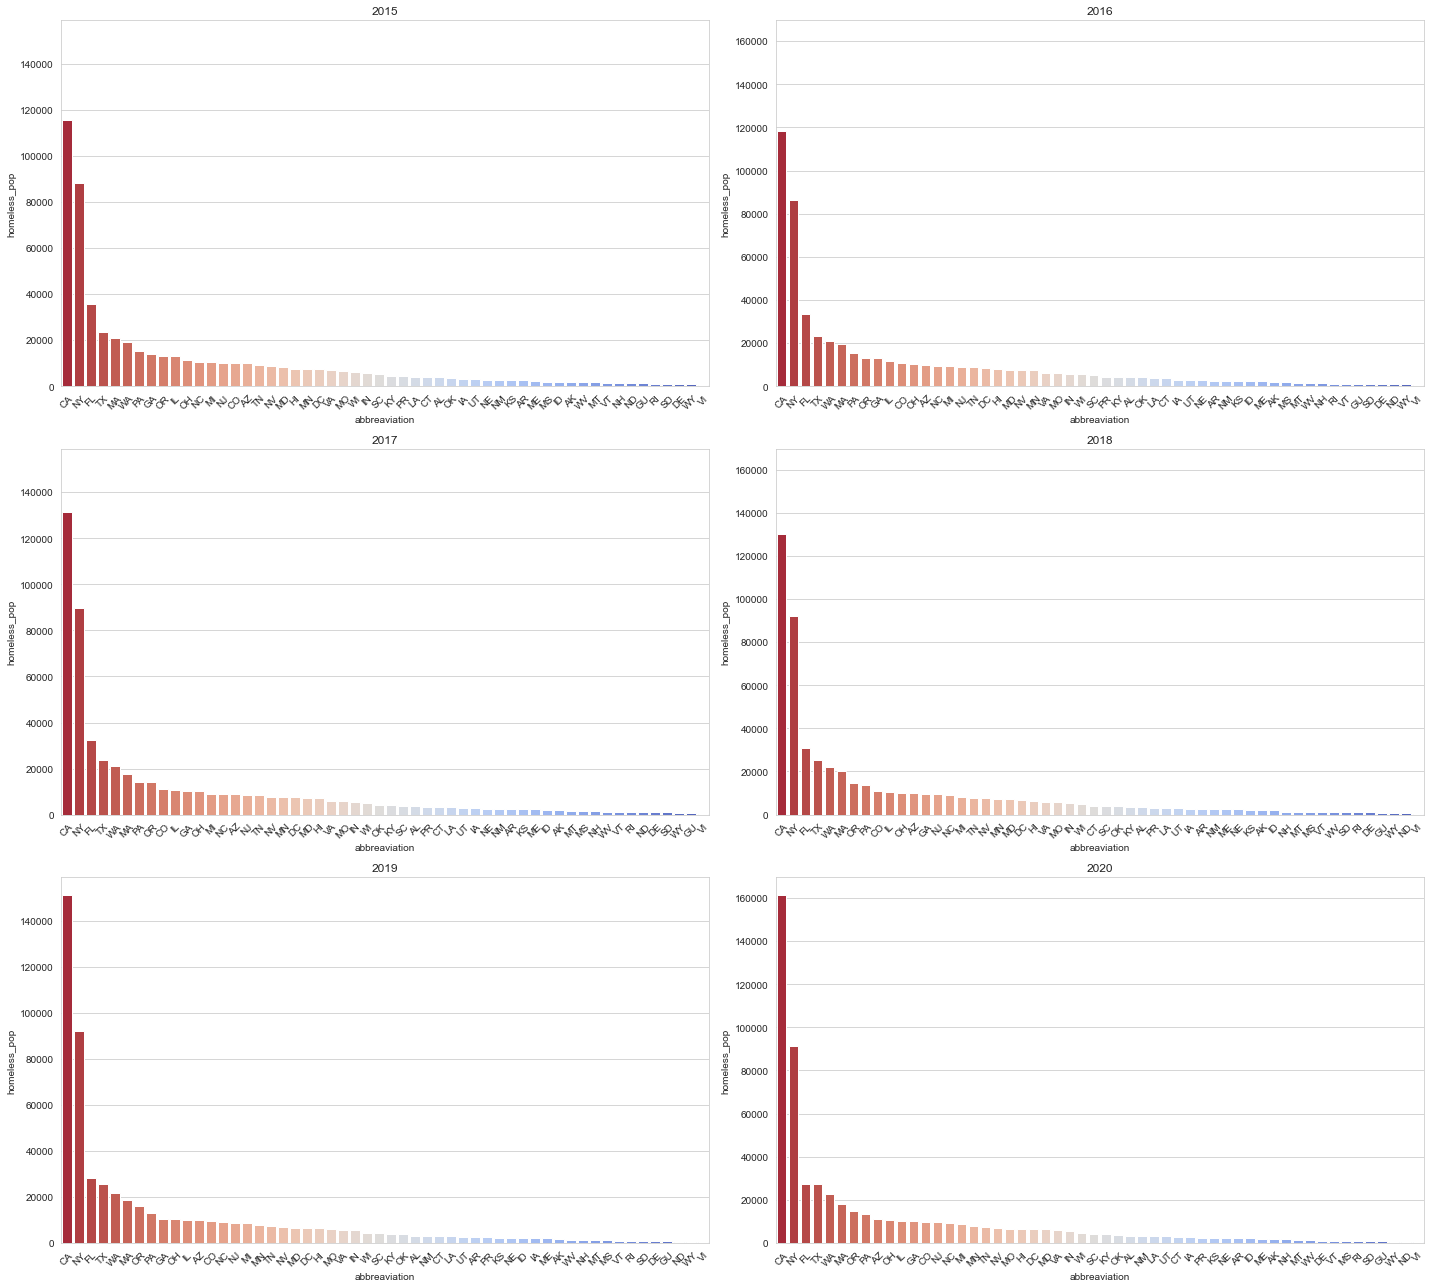

In [17]:
_, axes = plt.subplots(3, 2, figsize=(20, 18), sharey='col')
for year, ax in zip(years, axes.ravel()):
    df2 = df_clean[df_clean["year"] == year].sort_values(by="homeless_pop", ascending=False)
    g = sns.barplot(x="abbreaviation", y="homeless_pop", data=df2,
                    palette="coolwarm_r", ax=ax)
    g.set_title(year)
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Top 10 States Overall Homeless population from 2016 - 2020

Based on those figures, CA is the state with a higher homeless population. Besides, there were no massive changes in the states with homeless people during the last four years.

Let's see what are the top 10 states

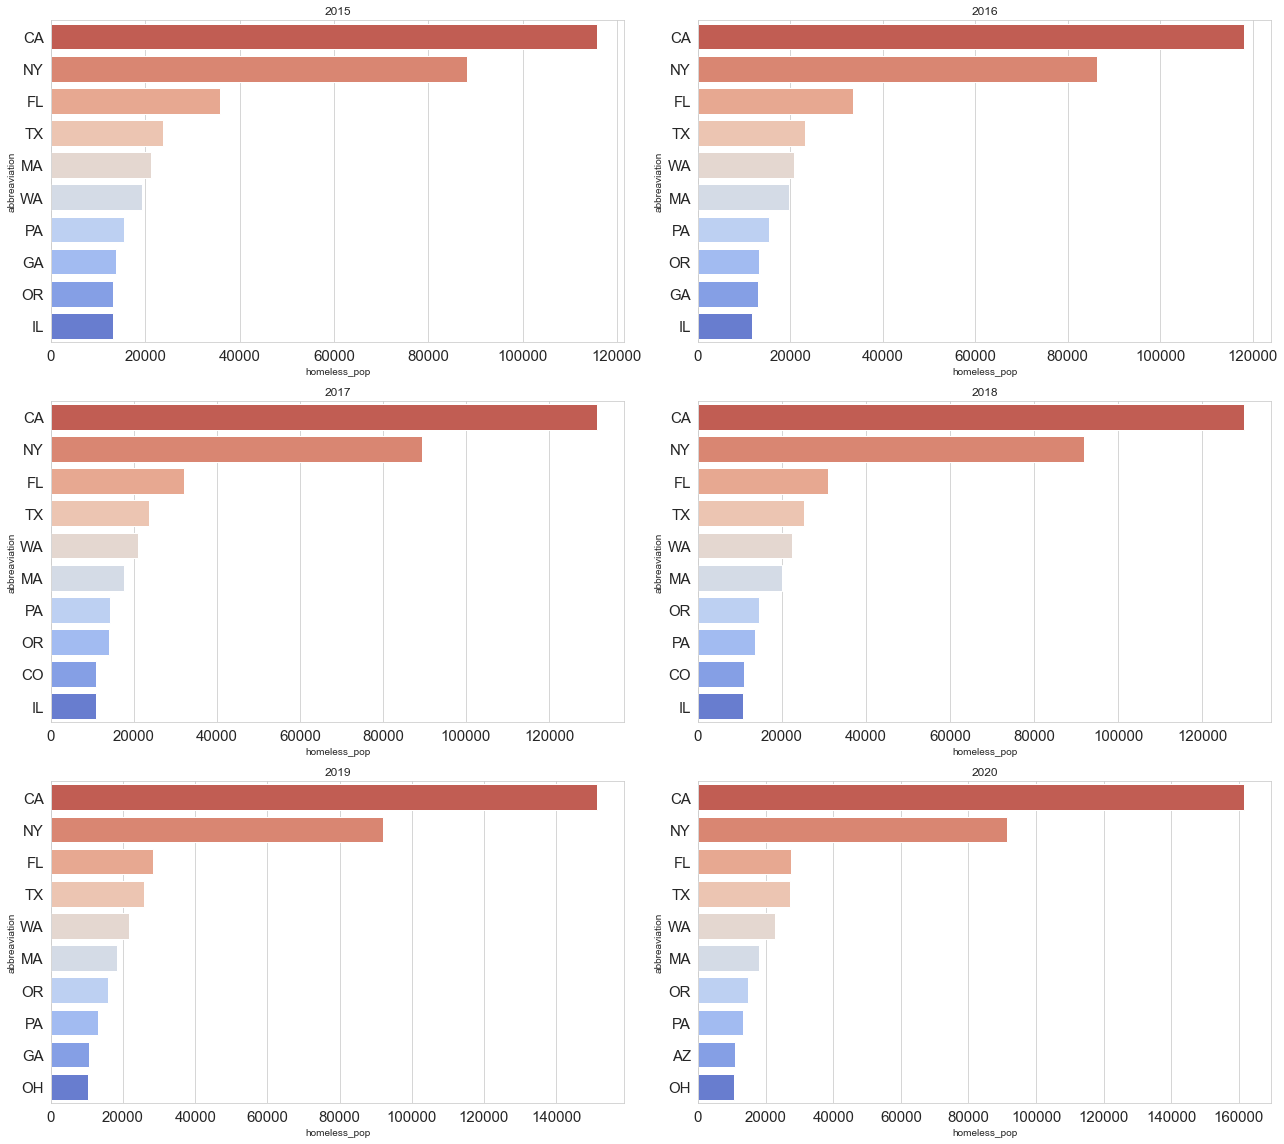

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
for year, ax in zip(years, axes.ravel()):
    df2 = df_clean[df_clean["year"] == year].sort_values(by="homeless_pop", ascending=False)
    g = sns.barplot(y="abbreaviation", x="homeless_pop", data=df2.head(10),
                    palette="coolwarm_r", ax=ax, orient="h")
    g.set_title(year)
    g.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

## Select the top 10 States with higher overall homeless population

The top ten states list isn't kept constant during the period study. Let's find out which states were on the list

### Identify the index of the top 10 states for each year

In [19]:
list_top_states = []
for year in years:
    list_top_states.extend(df_clean[df_clean["year"] == year].sort_values(by="homeless_pop", ascending=False).head(10).index.to_list())

top_states = list(set(list_top_states))

In [20]:
top_states_df = df_clean.loc[top_states]
top_states_df.reset_index(inplace=True, drop=True)

In [21]:
# This is a dataframe where the top 10 states for each year is shown
top_states_df.head()

,year,abbreaviation,homeless_pop
0,2018,TX,25310.0
1,2020,TX,27229.0
2,2016,TX,23122.0
3,2017,TX,23548.0
4,2019,TX,25848.0


### What are the states with higher homeless population from 2015 to 2020

Now let's see which states are appeared on the top 10 list at least once

In [22]:
name_top_states = top_states_df["abbreaviation"].unique().tolist()
print("There are {} states that has been reported in the top 10 homeless population between {} and {}".format(
    len(name_top_states), min(years), max(years)
))

There are 13 states that has been reported in the top 10 homeless population between 2015 and 2020


### What are those states located on the US map

In [23]:
query = ("SELECT sr.abbreviation, sr.name, sr.region "
         "FROM state_region AS sr "
         "WHERE sr.abbreviation IN (" + "'" +"','".join(name_top_states) + "')")

In [24]:
cursor = connect_database("heroku", "c1_capstone", keys)
cursor.execute(query)
results = cursor.fetchall()
cursor.close()
which_states = pd.DataFrame(results, columns=['Abbr', 'State', 'Region'])
which_states


,Abbr,State,Region
0,AZ,Arizona,Southwest
1,CA,California,West
2,CO,Colorado,West
3,FL,Florida,South
4,GA,Georgia,South
5,IL,Illinois,Midwest
6,MA,Massachusetts,New England
7,NY,New York,Middle Atlantic
8,OH,Ohio,Midwest
9,OR,Oregon,West


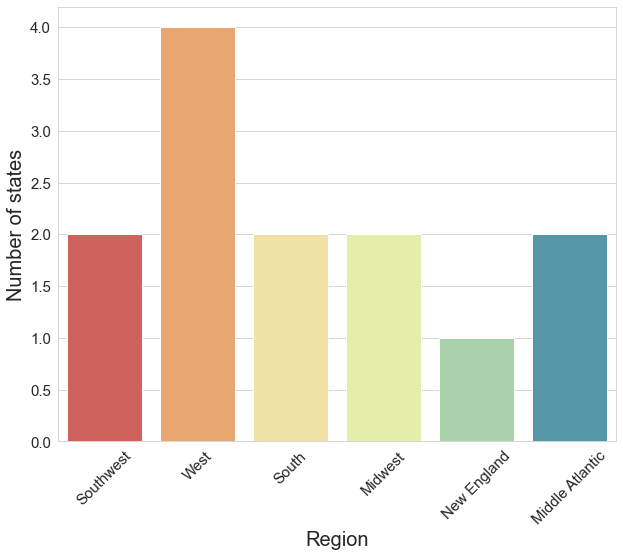

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.countplot(x='Region', data=which_states, palette="Spectral")
ax.set_ylabel('Number of states', fontsize=20)
ax.set_xlabel('Region', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=15, labelrotation=45)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()

From the last figure, it can be shown the US-region where most high-homeless population states are located in the West region.

## How has change the homeless population of those states over time?

In order to show the variation over time, let's do a lineplot.

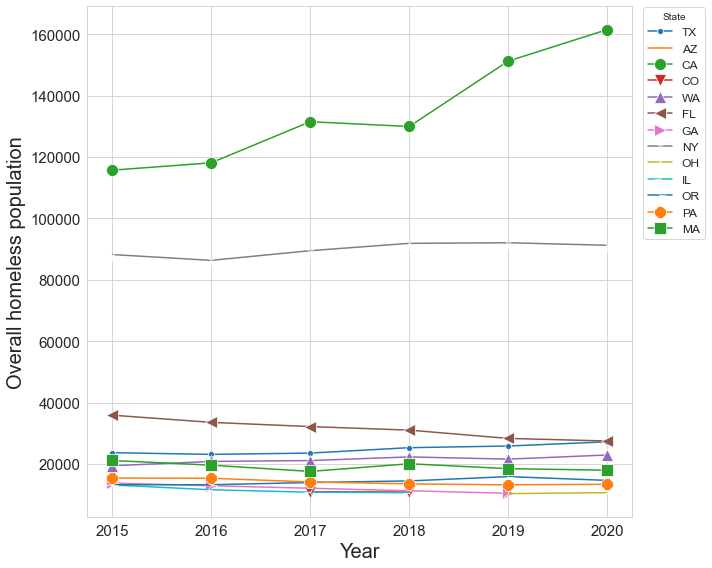

In [26]:
_, ax = plt.subplots(figsize=(10, 8))
for i, state in enumerate(name_top_states):
    _ = sns.lineplot(x="year", y="homeless_pop",
                     data=top_states_df[top_states_df["abbreaviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i],
                     markersize=12)

ax.set_ylabel('Overall homeless population', fontsize=20)
ax.legend(labels=name_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

Based on this figure, California (CA) is the state where the homelessness population has increased the most from 2018 to 2020. The New York state (NY) has shown a continuous homelessness increase.

In contrast, Florida (FL) has shown a continuous decrease since 2015. Let's see the behaviour of the rest of the states.

Due the magnitud order, the homeless population for the rest of the states has been shrunk to the plot bottom. Because of that, let's split the graph

In [27]:
out_state = ['CA', 'NY', 'FL']
new_top_states = [i for i in name_top_states if i not in out_state]

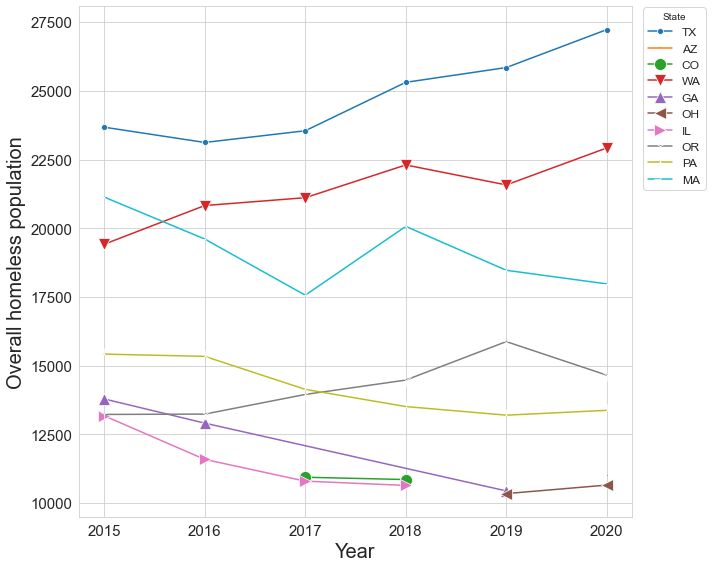

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
for i, state in enumerate(new_top_states):
    _ = sns.lineplot(x="year", y="homeless_pop", data=top_states_df[top_states_df["abbreaviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i], markersize=12)

ax.set_ylabel('Overall homeless population', fontsize=20)
ax.legend(labels=new_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

## Ratio Homeless population vs Total population in Top States

Let's see who the homeless population has changed respect the total population

## Grab info from population, homeless and state_region database

In [29]:
query = ("SELECT upop.year, sr.abbreviation, upop.population, ovh.homeless_pop "
         "FROM us_population AS upop "
         "JOIN state_region AS sr "
         " ON upop.id_state = sr.state "
         "JOIN overall_homeless ovh "
         " ON (upop.year = ovh.year) AND (sr.abbreviation = ovh.abbreaviation) "
         "WHERE ovh.abbreaviation in ('TX', 'AZ', 'CA', 'CO', 'WA', 'FL', 'GA', 'NY', 'OH', 'IL', 'OR', 'PA', 'MA') "
         "ORDER BY upop.year, upop.id_state ")

In [30]:
cursor = connect_database("heroku", "c1_capstone", keys)
cursor.execute(query)
results = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
cursor.close()

In [31]:
df = pd.DataFrame(results, columns=column_names)

In [32]:
df["% homeless"] = df["homeless_pop"] /df["population"] * 100

In [33]:
df.head()

,year,abbreviation,population,homeless_pop,% homeless
0,2015,AZ,6828065,9896,0.144931
1,2015,CA,39144818,115738,0.295666
2,2015,CO,5456574,9953,0.182404
3,2015,FL,20271272,35900,0.177098
4,2015,GA,10214860,13790,0.134999


Let's plot the % homeless by state over time

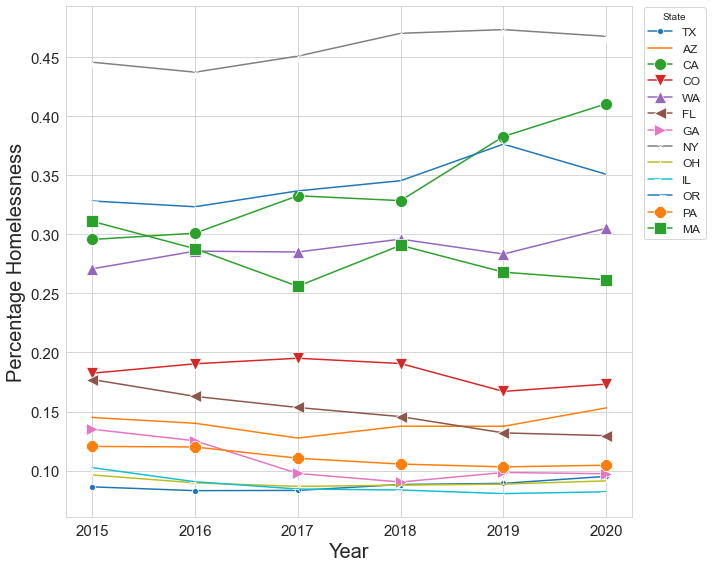

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
for i, state in enumerate(name_top_states):
    _ = sns.lineplot(x="year", y="% homeless", data=df[df["abbreviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i], markersize=12)

ax.set_ylabel('Percentage Homelessness', fontsize=20)
ax.legend(labels=name_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

From the graph, the set of top homeless population states can be split at 0.25% level.

In [35]:
df1 = df[df["% homeless"] > 0.25]
df2 = df[df["% homeless"] < 0.25]

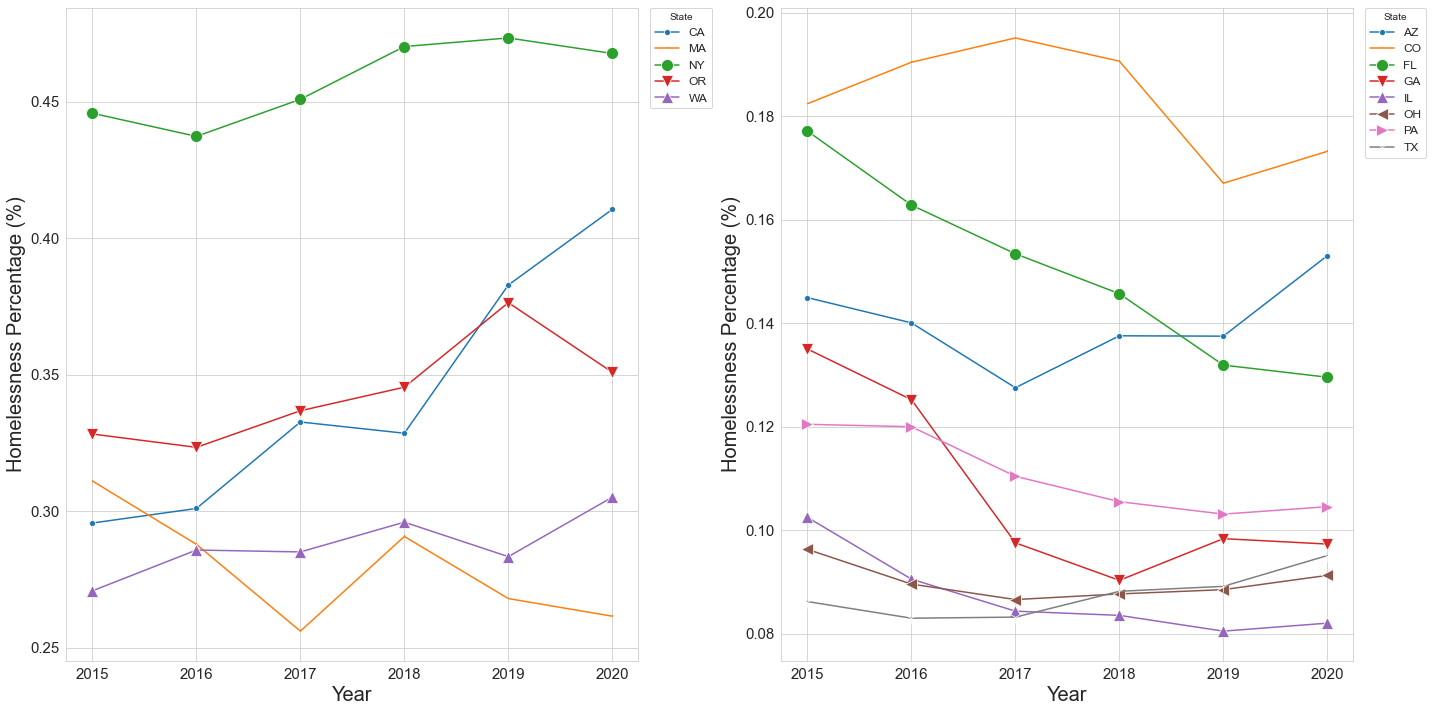

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
for i, state in enumerate(df1["abbreviation"].unique().tolist()):
    _ = sns.lineplot(x="year", y="% homeless", data=df1[df1["abbreviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i], markersize=12, ax=ax1)

ax1.set_ylabel('Homelessness Percentage (%)', fontsize=20)
ax1.legend(labels=df1["abbreviation"].unique().tolist(), title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax1.set_xlabel('Year', fontsize=20)
ax1.tick_params(which='major', labelsize=15)

for i, state in enumerate(df2["abbreviation"].unique().tolist()):
    _ = sns.lineplot(x="year", y="% homeless", data=df2[df2["abbreviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i], markersize=12, ax=ax2)

ax2.set_ylabel('Homelessness Percentage (%)', fontsize=20)
ax2.legend(labels=df2["abbreviation"].unique().tolist(), title = "State",
           fontsize = 'large',
           bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax2.set_xlabel('Year', fontsize=20)
ax2.tick_params(which='major', labelsize=15)

plt.tight_layout()
plt.show()

In [37]:
df.groupby(["abbreviation"])["% homeless"].agg(['mean', 'std']).sort_values(by="std", ascending=False)

,mean,std
abbreviation,,
CA,0.341894,0.045757
MA,0.279207,0.020963
OR,0.343536,0.019093
FL,0.150073,0.018300
GA,0.107287,0.018175
NY,0.457563,0.014874
WA,0.287690,0.011720
CO,0.183129,0.011054
AZ,0.140096,0.008513


From the latter result, the state with high % homeless variation is California. In contrast, the state of Georgia, New York, and Washington has showed low variation, while the rest of the states have the same variation level during the study timespan.

The state of NY shows a high % homeless and low variation over time.

### State of New York

In [43]:
df[df["abbreviation"]=='NY']

,year,abbreviation,population,homeless_pop,% homeless
7,2015,NY,19795791,88250,0.445802
20,2016,NY,19745289,86352,0.437330
33,2017,NY,19849399,89503,0.450910
46,2018,NY,19542209,91897,0.470249
59,2019,NY,19453561,92091,0.473389
72,2020,NY,19514849,91271,0.467700


### State of Florida

In [44]:
df[df["abbreviation"]=='FL']

,year,abbreviation,population,homeless_pop,% homeless
3,2015,FL,20271272,35900,0.177098
16,2016,FL,20612439,33559,0.162809
29,2017,FL,20984400,32190,0.153400
42,2018,FL,21299325,31030,0.145685
55,2019,FL,21477737,28328,0.131895
68,2020,FL,21216924,27487,0.129552


# Selection the states for the study

The selection of states will be those whose average % homeless is higher than 0.1%

In [45]:
df_final = df.groupby(["abbreviation"])["% homeless"].agg(['mean', 'std']).sort_values(by="mean", ascending=False)

In [53]:
df_final[df_final["mean"] > 0.1].index.tolist()

['NY', 'OR', 'CA', 'WA', 'MA', 'CO', 'FL', 'AZ', 'PA', 'GA']